# Tensor Components Analysis (TCA) for Recurrent Convolutional Nets

Ted Moskovitz, 2019

This notebook is much less organized, as I ultimately felt that the results were not all that interpretable and it was very computationally expensive to analyze anything not of low rank. It mostly just applies Alex Williams' implementation of TCA (in the library `tensortools`) to the network activities.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensortools as tt
import pickle
import os
import itertools
from files import get_files

np.random.seed(324)

%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = (16.0, 6.0)
plt.rcParams['font.size'] = 22

**load the data**

In [2]:
data_dir = "/labs/common/share/"
#print (os.listdir(data_dir))
file_dict = get_files(ftype="activity")

In [4]:
# load the data 
activity_dict = {}
for net in file_dict.keys():
    activity_dict[net] = [] 
    for a in file_dict[net]:
        with open(data_dir + a, 'rb') as f:
            activity_dict[net].append(pickle.load(f))
            
    print ("finished loading {}.".format(net))

finished loading supralinear.
finished loading linear.
finished loading local10_linear.
finished loading local40_supralinear.
finished loading local40_supralinear_VC.
finished loading local20_linear_posInput.
finished loading local10_linear_VC.
finished loading local25_supralinear_VC.
finished loading local20_linear_posInput_EOutput.
finished loading local20_supralinear_VC_posInput.
finished loading local20_linear_VC_posInput.
finished loading local20_supralinear_posInput.
finished loading local20_supralinear_VC.
finished loading local20_linear_VC.
finished loading local20_supralinear_VC_posInput_EOutput.


**Fit TCA, Analyze Dimensionality**

In [14]:
# Fit ensemble of unconstrained tensor decompositions.
methods = [
    'cp_als'
]
#    'ncp_bcd',
#    'ncp_hals'
np.random.seed(324)

layer = "conv4_state"
R = 10

# iterate over networks
for model in activity_dict:
    
    print ("Fitting {}...".format(model))
    
    X = np.stack(activity_dict[model][0][layer])
    T, N, H, W, C = X.shape
    X = X.reshape(T, N, H*W, C)
    Xn = np.maximum(0, X + 0.05*np.random.randn(T, N, H*W, C))

    ensembles = {}
    for m in methods:
        ensembles[m] = tt.Ensemble(fit_method=None, fit_options=dict(tol=1e-4))
        ensembles[m].fit(Xn, ranks=range(1, R), replicates=3) #3 replicates
        
    print ("\n Done. \n =================================== \n")

Fitting supralinear...


Fitting rank-2 models:   0%|          | 0/3 [00:00<?, ?it/s]        

Rank-1 models:  min obj, 0.95;  max obj, 0.95;  time to fit, 196.1s


Fitting rank-3 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-2 models:  min obj, 0.94;  max obj, 0.94;  time to fit, 491.3s


Fitting rank-4 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-3 models:  min obj, 0.94;  max obj, 0.94;  time to fit, 447.2s


Fitting rank-5 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-4 models:  min obj, 0.93;  max obj, 0.94;  time to fit, 509.8s


Fitting rank-6 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-5 models:  min obj, 0.93;  max obj, 0.93;  time to fit, 517.8s


Fitting rank-7 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-6 models:  min obj, 0.93;  max obj, 0.93;  time to fit, 652.4s


Fitting rank-8 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-7 models:  min obj, 0.93;  max obj, 0.93;  time to fit, 719.9s


Fitting rank-9 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-8 models:  min obj, 0.92;  max obj, 0.93;  time to fit, 980.7s


Rank-9 models:  min obj, 0.92;  max obj, 0.92;  time to fit, 1028.5s

 Done. 

Fitting linear...


Fitting rank-2 models:   0%|          | 0/3 [00:00<?, ?it/s]        

Rank-1 models:  min obj, 0.92;  max obj, 0.92;  time to fit, 173.5s


Fitting rank-3 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-2 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 409.6s


Fitting rank-4 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-3 models:  min obj, 0.91;  max obj, 0.91;  time to fit, 635.2s


Fitting rank-5 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-4 models:  min obj, 0.90;  max obj, 0.91;  time to fit, 425.7s


Fitting rank-6 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-5 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 771.6s


Fitting rank-7 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-6 models:  min obj, 0.90;  max obj, 0.90;  time to fit, 692.7s


Fitting rank-8 models:   0%|          | 0/3 [00:00<?, ?it/s]         

Rank-7 models:  min obj, 0.89;  max obj, 0.89;  time to fit, 949.6s


Fitting rank-8 models:  67%|██████▋   | 2/3 [08:41<04:25, 265.62s/it]

KeyboardInterrupt: 

In [5]:
# TCA on Activities

layer = "conv5_state"
tensors = []
R = 4 # set rank
n = 250 # set number of examples to use
for i,model in enumerate(list(activity_dict.keys())):
    
    print ("{}/{} Fitting {}...".format(i+1, len(list(activity_dict.keys())), model))

    X = np.stack(activity_dict[model][0][layer])# [-1]
    X = X[:, :n, :, : :]
    
    # pre-process to remove any NaNs or infs; replace with maximum of valid values
    high = np.max(X[np.invert(np.logical_or(np.isnan(X), np.isinf(X)))])
    X[np.isinf(X)] = high
    X[np.isnan(X)] = high
    
    T, N, H, W, C = X.shape
    X = X.reshape(T, N, H*W, C)
    Xn = np.maximum(0, X + 0.05*np.random.randn(T, N, H*W, C))
    
    # Fit CP tensor decomposition (two times).
    U = tt.cp_als(Xn, rank=R, verbose=True)
    tensors.append(U)
    
    print ("\n =================================== \n")

1/8 Fitting supralinear...
CP_ALS: iteration 1, objective 0.9750719497471195, improvement inf.
CP_ALS: iteration 2, objective 0.9482846867721931, improvement 0.026787262974926396.
CP_ALS: iteration 3, objective 0.9450728333782146, improvement 0.0032118533939785587.
CP_ALS: iteration 4, objective 0.9437145388876829, improvement 0.0013582944905317085.
CP_ALS: iteration 5, objective 0.9430031930598316, improvement 0.0007113458278512619.
CP_ALS: iteration 6, objective 0.9425606713064267, improvement 0.00044252175340486755.
CP_ALS: iteration 7, objective 0.9422433243689716, improvement 0.00031734693745510967.
CP_ALS: iteration 8, objective 0.9419922018913404, improvement 0.0002511224776312604.
CP_ALS: iteration 9, objective 0.9417809327439692, improvement 0.00021126914737112923.
CP_ALS: iteration 10, objective 0.9415946389709254, improvement 0.00018629377304379968.
CP_ALS: iteration 11, objective 0.9414223352891106, improvement 0.0001723036818148671.
CP_ALS: iteration 12, objective 0.941259

CP_ALS: iteration 40, objective 0.9398622706969186, improvement 3.2246374165212366e-05.
CP_ALS: iteration 41, objective 0.939829750517632, improvement 3.252017928667694e-05.
CP_ALS: iteration 42, objective 0.9397977872889868, improvement 3.1963228645182085e-05.
CP_ALS: iteration 43, objective 0.9397671597982419, improvement 3.062749074489446e-05.
CP_ALS: iteration 44, objective 0.9397384880979999, improvement 2.8671700242011156e-05.
CP_ALS: iteration 45, objective 0.939712191619184, improvement 2.6296478815912572e-05.
CP_ALS: iteration 46, objective 0.939688502530005, improvement 2.368908917893542e-05.
CP_ALS: iteration 47, objective 0.9396675023500416, improvement 2.100017996342629e-05.
CP_ALS: iteration 48, objective 0.939649154936607, improvement 1.8347413434649518e-05.
CP_ALS: iteration 49, objective 0.9396333281203851, improvement 1.5826816221808926e-05.
CP_ALS: iteration 50, objective 0.9396198106878952, improvement 1.3517432489895675e-05.
CP_ALS: iteration 51, objective 0.939608

CP_ALS: iteration 5, objective 0.9397314615040014, improvement 0.0007968726280283001.
CP_ALS: iteration 6, objective 0.9394411212108414, improvement 0.0002903402931599963.
CP_ALS: iteration 7, objective 0.9393300614244722, improvement 0.00011105978636927194.
CP_ALS: iteration 8, objective 0.9392734637847956, improvement 5.6597639676581046e-05.
CP_ALS: iteration 9, objective 0.9392357539865603, improvement 3.7709798235252556e-05.
CP_ALS: iteration 10, objective 0.9392064397409934, improvement 2.9314245566958164e-05.
CP_ALS: iteration 11, objective 0.9391816412211825, improvement 2.479851981085357e-05.
CP_ALS: iteration 12, objective 0.9391593609111706, improvement 2.228031001194619e-05.
CP_ALS: iteration 13, objective 0.9391382170511974, improvement 2.1143859973205004e-05.
CP_ALS: iteration 14, objective 0.9391170696227928, improvement 2.114742840453321e-05.
CP_ALS: iteration 15, objective 0.9390948890034627, improvement 2.2180619330125495e-05.
CP_ALS: iteration 16, objective 0.93907069

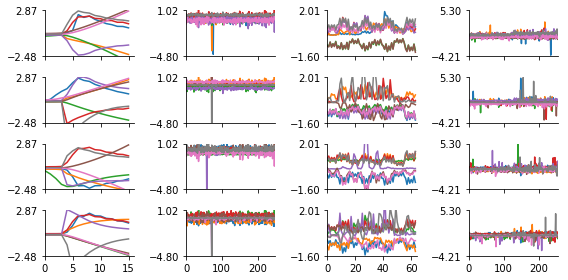

In [6]:
# un-alligned

# Compare the low-dimensional factors from the two fits.
for i,M in enumerate(tensors):
    if i == 0:
        fig, ax, po = tt.plot_factors(M.factors)
    else:
        tt.plot_factors(M.factors, fig=fig)

plt.show()

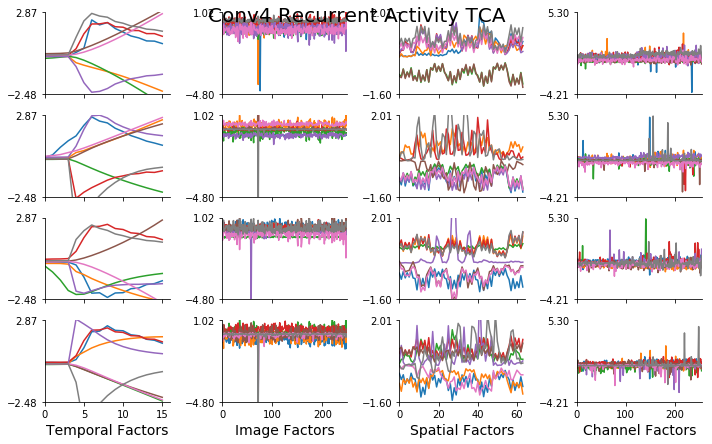

In [7]:
# Compare the low-dimensional factors from the two fits.
for i,M in enumerate(tensors):
    if i == 0:
        fig, ax, po = tt.plot_factors(M.factors, figsize=(10, 6))
    else:
        tt.plot_factors(M.factors, fig=fig)
        
# Show plots.
ax[-1,0].set_xlabel("Temporal Factors", fontsize=14)
ax[-1,1].set_xlabel("Image Factors", fontsize=14)
ax[-1,2].set_xlabel("Spatial Factors", fontsize=14)
ax[-1,3].set_xlabel("Channel Factors", fontsize=14)
fig.suptitle("Conv4 Recurrent Activity TCA", fontsize=20)

plt.show()

0.6552169058328394
0.6969706261857086
0.7077594398320326
0.6044333476865795
0.6225908642377973
0.6728998304669989
0.5855290389963321
0.7165555984074526
0.7182134266494831
0.6353374032218944
0.7786701865021616
0.7490605689611786
0.630206406553357
0.671065451640712
0.5754199775769511
0.6890643616491756
0.6977620856124138
0.5709484556779808
0.6799973586237642
0.6874778151604352
0.7386453743527597
0.6513133635290995
0.6388585844861229
0.6278107545284238
0.6368026151885469
0.792509283196616
0.5913950085059264
0.5847906491268857


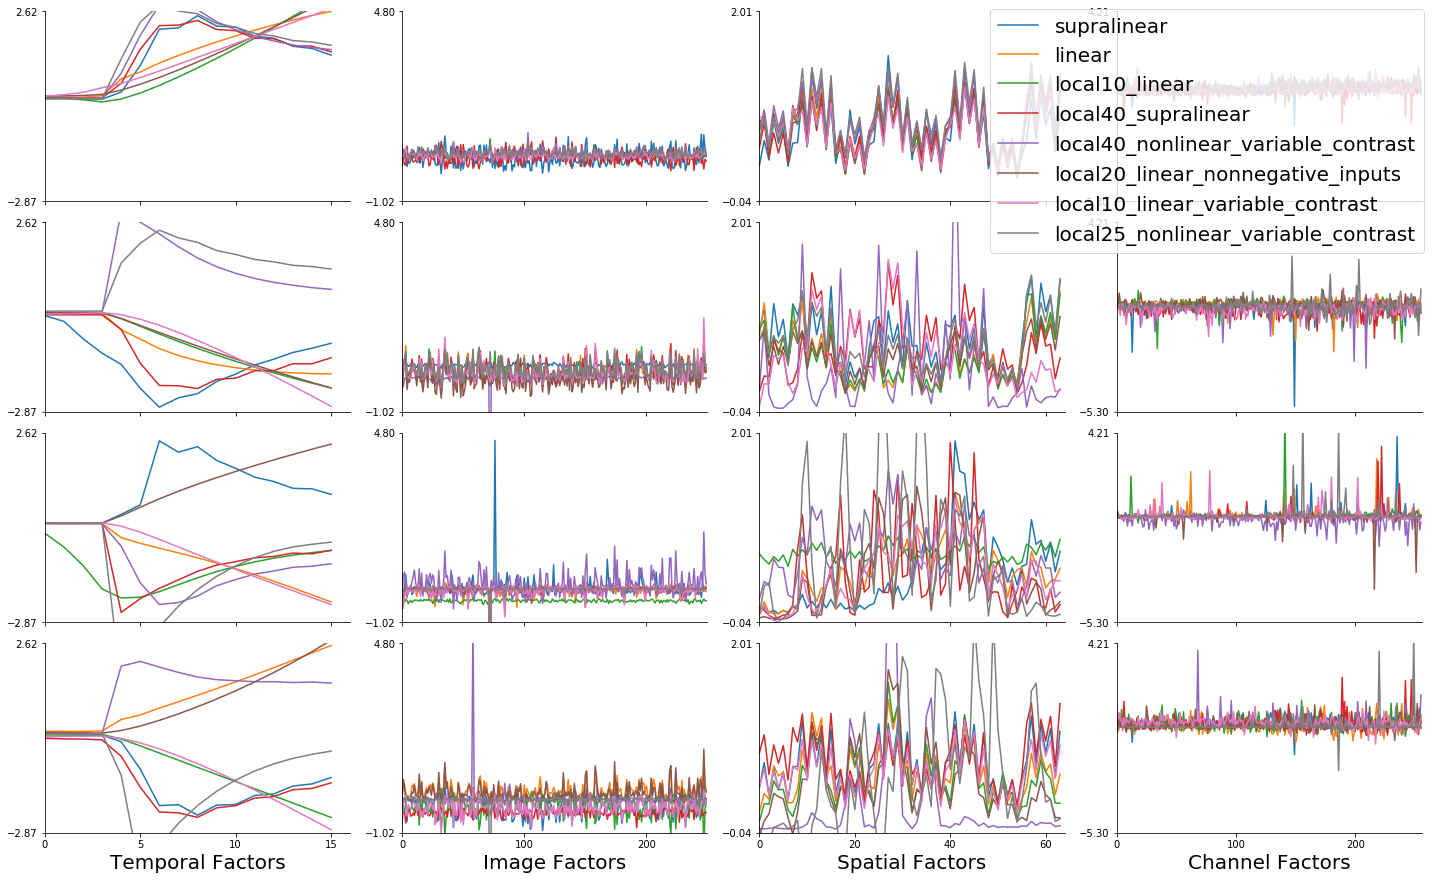

In [8]:
# Align the pair-wise fits and print a similarity score.
for U,V in list(itertools.combinations(tensors, 2)):
    sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True)

# Compare the low-dimensional factors from the two fits.
line_kw = [{"lw":3} for _ in range(R)]
for i,M in enumerate(tensors):
    if i == 0:
        fig, ax, po = tt.plot_factors(M.factors, figsize=(20, 12))
    else:
        tt.plot_factors(M.factors, fig=fig)
        
# Show plots.

ax[-1,0].set_xlabel("Temporal Factors", fontsize=20)
ax[-1,1].set_xlabel("Image Factors", fontsize=20)
ax[-1,2].set_xlabel("Spatial Factors", fontsize=20)
ax[-1,3].set_xlabel("Channel Factors", fontsize=20)
#fig.suptitle("Conv4 Recurrent Activity TCA", fontsize=20)
labels = list(activity_dict.keys())
fig.legend(labels, fontsize=20)

plt.show()